# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.integrate import quad
import time
import re
import os

ModuleNotFoundError: No module named 'seaborn'

# Useful custom defs

## defs

In [ ]:
def count_max(df:pd.DataFrame, col: str, threshold: float=1) -> int:
    """
    count maxima [above threshold magnitude] in certain column of df
    args:
    df -- dataframe
    col -- column of df
    threshold -- coefficient used for pd.Series.std() multiplication (default=1)
    returns: # of x s.t. x E [threshold + mean; +inf)
    """
    counter = 0
    cur_df = df
    col_mean = cur_df[col].mean()
    cur_max = cur_df[col].max()
    print(f"df[col]: {df.head(1)[col]}")
    print(f"bounds: {col_mean}")
    print(f"Initial max: {cur_max}")
    while cur_max > df[col].mean() + threshold*df[col].std(): # std normalized to N-1
        print(f"Current maximum: {cur_max}")
        counter += 1
        cur_df = cur_df[cur_df[col] != cur_max]
        cur_max = cur_df[col].max()
        continue
    print(f"Found {counter} maxima/maximum")
    return counter

def count_min(df:pd.DataFrame, col: str, threshold: float=1) -> int:
    """
    count minima [below threshold magnitude] in certain column of df
    args:
    df -- dataframe
    col -- column of df
    threshold -- coefficient used for pd.Series.std() multiplication (default=1)
    returns: # of x s.t. x E (-inf; -threshold + mean]
    """
    counter = 0
    cur_df = df
    col_mean = cur_df[col].mean()
    cur_min = cur_df[col].min()
    print(f"df[col]: {df.head(1)[col]}")
    print(f"bounds: {col_mean}")
    print(f"Initial min: {cur_min}")
    while cur_min < df[col].mean() - threshold*df[col].std(): # std normalized to N-1
        print(f"Current minimum: {cur_min}")
        counter += 1
        cur_df = cur_df[cur_df[col] != cur_min]
        cur_min = cur_df[col].min()
        continue
    print(f"Found {counter} minima/minimum")
    return counter
    

def clean_multiple_xtrma(df: pd.DataFrame, col: str, threshold: tuple[float, float]=(1.1, 1.1)) -> pd.DataFrame:
    """
    clean multiple extreme outliers, by finding
    # of min
    # max
    to remove and removing min from df[col] n_min times
              and removing max from df[col] n_max times
    returns: df w/o extreme outliers
    """
    new_df = df
    n_min = count_min(df, col, threshold[0])
    n_max = count_max(df, col, threshold[1])
    for _ in range(n_min):
        new_df = new_df[df[col] > df[col].min()] 

    for _ in range(n_max):
        new_df = new_df[df[col] < df[col].max()]

    return new_df

def dir_match(path: str, pattern: str) -> list[str]:
    matched = []
    dir_contents = sorted(os.listdir(path))
    for item in dir_contents:
        if re.match(pattern, item) is not None:
            matched.append(item)
    return matched

def subtract_hex(n1: str, n2: str) -> str:
    h1 = int(n1, 16)
    h2 = int(n2,16)
    return hex(abs(h1-h2))

def sum_hex(n1: str, n2: str) -> str:
    h1 = int(n1, 16)
    h2 = int(n2, 16)
    return hex(h1+h2)

## tests

In [ ]:
path = './datas/full_tests/'
path2 = './datas/freq_tests/1/'
freq_list = [20, 32, 42, 74, 98, 130, 171, 227, 300]
for i in freq_list:
    test_pattern = re.compile(f".+600_51_{i}.+")
    print(dir_match(path2, test_pattern))

['gasx_600_51_20__msr__0', 'gasx_600_51_20__msr__1', 'gasx_600_51_20__msr__2']
['gasx_600_51_32__msr__3', 'gasx_600_51_32__msr__4', 'gasx_600_51_32__msr__5']
['gasx_600_51_42__msr__6', 'gasx_600_51_42__msr__7', 'gasx_600_51_42__msr__8']
['gasx_600_51_74__msr__10', 'gasx_600_51_74__msr__11', 'gasx_600_51_74__msr__9']
['gasx_600_51_98__msr__12', 'gasx_600_51_98__msr__13', 'gasx_600_51_98__msr__14']
['gasx_600_51_130__msr__15', 'gasx_600_51_130__msr__16', 'gasx_600_51_130__msr__17']
['gasx_600_51_171__msr__18', 'gasx_600_51_171__msr__19', 'gasx_600_51_171__msr__20']
['gasx_600_51_227__msr__21', 'gasx_600_51_227__msr__22', 'gasx_600_51_227__msr__23']
['gasx_600_51_300__msr__24', 'gasx_600_51_300__msr__25', 'gasx_600_51_300__msr__26']


# For analysis

## 16.05.2025 Single point test data analysis

/tmp/ipykernel_7979/2168176887.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  single_point_test = pd.read_csv("./datas/point_tests/point0", sep=r'\s+', header=None, names=list(col_names.values()), index_col=False)


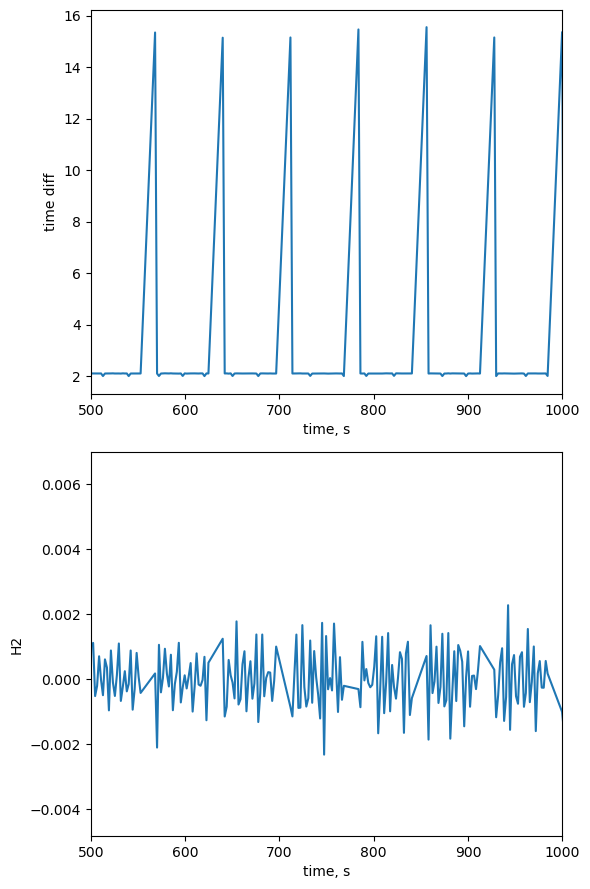

In [ ]:
col_names = {
    0: 'time',          # time (measurement tick, stopped on gasx, arbitrary)
    1: 'offset1',       # DFB offset-1
    2: 'P1',            # onboard pressure sensor (blue tube)
    3: 'H3',            # 3rd harmonic (L1H1)
    4: 'H2',            # 2nd harmonic (L1H2)
    5: 'P_las',         # laser power (some volts)
    6: 'T_las',         # diode temp (Kelvin)
    7: 'RH',            # humidity sensor (external)
    8: 'Pressure'       # sensor (external)
}

single_point_test = pd.read_csv("./datas/point_tests/point0", sep=r'\s+', header=None, names=list(col_names.values()), index_col=False)
single_point_test_gasx = pd.read_csv("./datas/point_tests/point_gasx_2", sep=r'\s+', header=None, names=list(col_names.values()), index_col=False)



df_single_diff = single_point_test_gasx.iloc[1:,:].copy().diff(axis=0, periods=1)
df_single = single_point_test_gasx.iloc[1:,:].copy()

# df_single['time'] -= df_single['time'].min()
plt.figure(figsize=(6, 9))
plt.subplot(211)
plt.plot(df_single['time'], df_single_diff['time'])
# plt.hlines(y=[df_single_diff['H2'].mean(), df_single_diff['H2'].mean() - df_single_diff['H2'].std(), df_single_diff['H2'].mean() + df_single_diff['H2'].std()], xmin=0, xmax=4000, colors=['black', 'red', 'red'])
plt.xlim(500, 1000)
plt.xlabel("time, s")
plt.ylabel("time diff")

plt.subplot(212)
plt.plot(df_single['time'], df_single_diff['H2'])
# plt.hlines(y=[df_single_diff['H2'].mean(), df_single_diff['H2'].mean() - df_single_diff['H2'].std(), df_single_diff['H2'].mean() + df_single_diff['H2'].std()], xmin=0, xmax=4000, colors=['black', 'red', 'red'])
plt.xlim(500, 1000)
plt.xlabel("time, s")
plt.ylabel("H2")

plt.tight_layout()
plt.show()

## Measurement visualization class

In [ ]:
class CEPAS_measurement():

    def __init__(self, path, path_signature: str, cols: dict) -> None:    
        self.path = path
        self.raw_spectra = [pd.read_csv(path+self.dir_match(path_signature)[i], sep=r'\s+', header=None, names=list(cols.values()), index_col=False) for i in range(len(self.dir_match(path_signature)))]

        self.spectra_list = [self.raw_spectra[i].iloc[1:,:].copy() for i, _ in enumerate(self.raw_spectra)]
        for df_idx in range(len(self.spectra_list)):
            self.spectra_list[df_idx].loc[:,'time_subtracted'] = self.spectra_list[df_idx]['time']           
            self.spectra_list[df_idx].loc[:,'time_subtracted'] -= self.spectra_list[df_idx]['time'].min()
            self.spectra_list[df_idx].loc[:,'H2_pnorm'] = self.spectra_list[df_idx].loc[:,'H2'] / (self.spectra_list[df_idx].loc[:,'P_las']+0.0025)
            self.spectra_list[df_idx].loc[:,'H3_pnorm'] = self.spectra_list[df_idx].loc[:,'H3'] / (self.spectra_list[df_idx].loc[:,'P_las']+0.0025)

        self.mean_humidities = {df_idx: self.spectra_list[df_idx]['RH'].mean() for df_idx in range(len(self.spectra_list))}
        self.mean_humidities_norm = np.array(list(self.mean_humidities.values()))/np.array(list(self.mean_humidities.values())).max()
        self.mean_humidities_norm = None

        # peak 1 idx 40-70
        self.peak_1s = [self.spectra_list[i].loc[40:70,:]['H2'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_1s_norm = [self.spectra_list[i].loc[40:70,:]['H2_pnorm'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_1s_norm_mins = [self.spectra_list[i].loc[40:70,:]['H2_pnorm'].min() for i, _ in enumerate(self.spectra_list)]
        self.ylim_11 = np.array(self.peak_1s_norm_mins).min() - 0.1
        self.ylim_12 = np.array(self.peak_1s_norm).max() + 0.1

        # peak 2 idx 150-175
        self.peak_2s = [self.spectra_list[i].loc[150:175,:]['H2'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_2s_norm = [self.spectra_list[i].loc[150:175,:]['H2_pnorm'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_2s_norm_mins = [self.spectra_list[i].loc[150:175,:]['H2_pnorm'].min() for i, _ in enumerate(self.spectra_list)]
        self.ylim_21 = np.array(self.peak_2s_norm_mins).min() - 0.1
        self.ylim_22 = np.array(self.peak_2s_norm).max() + 0.1

        self.pressures = [self.spectra_list[i]['Pressure'].unique() for i, _ in enumerate(self.spectra_list)]
    
    def water_plot(self, save: bool=False, save_path:str="water_plot") -> None:
        fig = plt.figure(figsize=(17, 11))  # noqa: F841

        ax0 = plt.subplot2grid(shape=(12, 12), loc=(6, 0), colspan=6, rowspan=6)
        for df_idx in range(len(self.spectra_list)):
            ax0.plot(self.spectra_list[df_idx].index, self.spectra_list[df_idx]['H2_pnorm'], label=f"{df_idx}")
        # ax0.set_xlim()
        # ax0.set_ylim(-0.5, 1)
        ax0.set_title("Power normalized spectrum")
        ax0.legend()
        ax0.set_xlabel("Arbitrary index")
        # ax0.set_xlabel("Laser current, arbitrary units")

        ax1 = plt.subplot2grid(shape=(12, 12), loc=(0, 6), colspan=5, rowspan=4)
        ax1.scatter(list(self.mean_humidities.keys()), self.mean_humidities_norm)
        ax1.set_xlabel('measurement #')
        ax1.set_ylabel('mean relative humidity, %')
        ax1.set_title("relative humidity over different measurement sessions")

        ax2 = plt.subplot2grid(shape=(12, 12), loc=(4, 6), colspan=5, rowspan=4)
        plt.scatter(list(range(len(self.peak_1s_norm))), self.peak_1s_norm)
        ax2.set_title("Peak 1 over sessions")
        ax2.set_xlabel("measurement #")
        ax2.set_ylabel("Normalized peak intensity")

        ax3 = plt.subplot2grid(shape=(12, 12), loc=(8, 6), colspan=5, rowspan=4)
        ax3.scatter(list(range(len(self.peak_2s_norm))), self.peak_2s_norm)
        ax3.set_title("Peak 2 over sessions")
        ax3.set_xlabel("measurement #")
        ax3.set_ylabel("Normalized peak intensity")



        ax4 = plt.subplot2grid(shape=(12, 12), loc=(0, 0), colspan=3, rowspan=6)
        for df_idx in range(len(self.spectra_list)):
            ax4.plot(self.spectra_list[df_idx].index, self.spectra_list[df_idx]['H2_pnorm'], label=f"{df_idx}")
        ax4.set_xlim(40, 75) # x=index
        ax4.set_ylim(self.ylim_11, self.ylim_12)
        ax4.set_title("Peak 1")
        ax4.legend()
        # plt.xlabel("time, s")
        ax4.set_xlabel("arbitrary index")

        ax5 = plt.subplot2grid(shape=(12, 12), loc=(0, 3), colspan=3, rowspan=6)
        for df_idx in range(len(self.spectra_list)):
            ax5.plot(self.spectra_list[df_idx].index, self.spectra_list[df_idx]['H2_pnorm'], label=f"{df_idx}")
        ax5.set_xlim(142, 182) # x=index
        ax5.set_ylim(self.ylim_21, self.ylim_22)
        ax5.set_title("Peak 2")
        ax5.legend()
        # plt.xlabel("time, s")
        ax4.set_xlabel("arbitrary index")

        plt.tight_layout()
        plt.show()

    def dir_match(self, pattern: str) -> list[str]:
        matched = []
        dir_contents = sorted(os.listdir(self.path))
        for item in dir_contents:
            if re.match(pattern, item) is not None:
                matched.append(item)
        return matched



# $p_{cell}\approx300\ \text{[mbar]}$

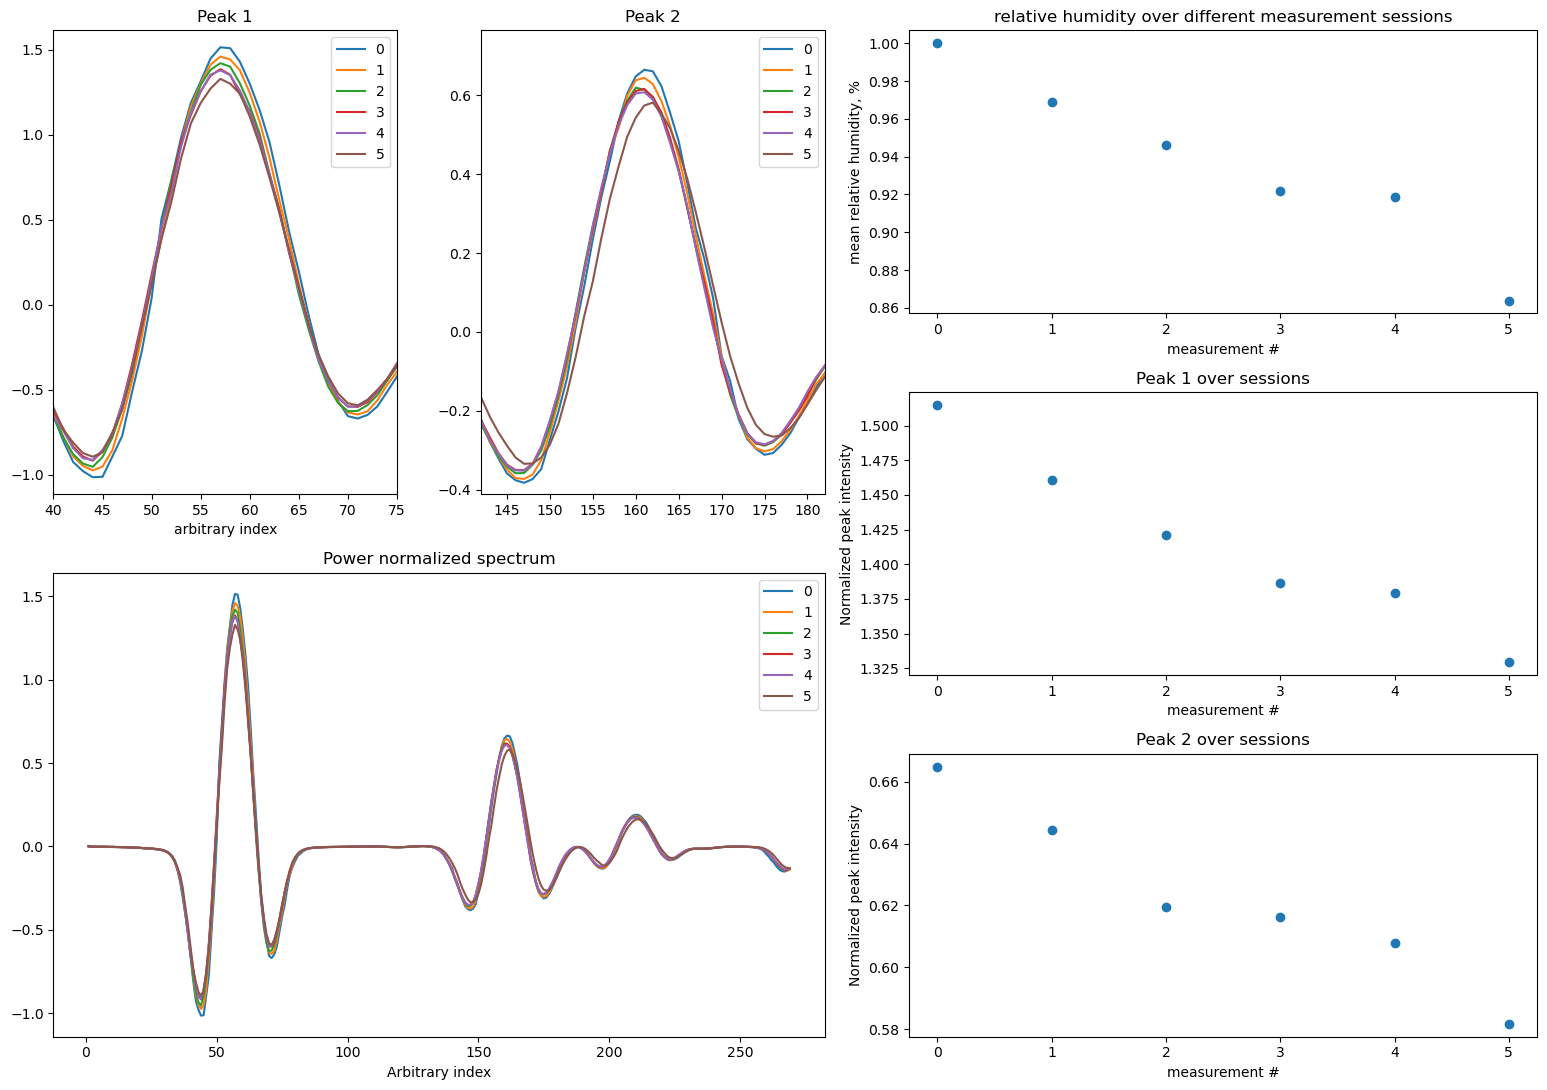

In [ ]:
path_sig = "gasx2__msr__"
cm1 = CEPAS_measurement(path, path_sig, col_names)
cm1.water_plot()

# $p_{cell}\approx600\ \text{[mbar]}$

After closer inspection, seems like in these measurements the power meter was not turned on, so the power normalization is just wrong here

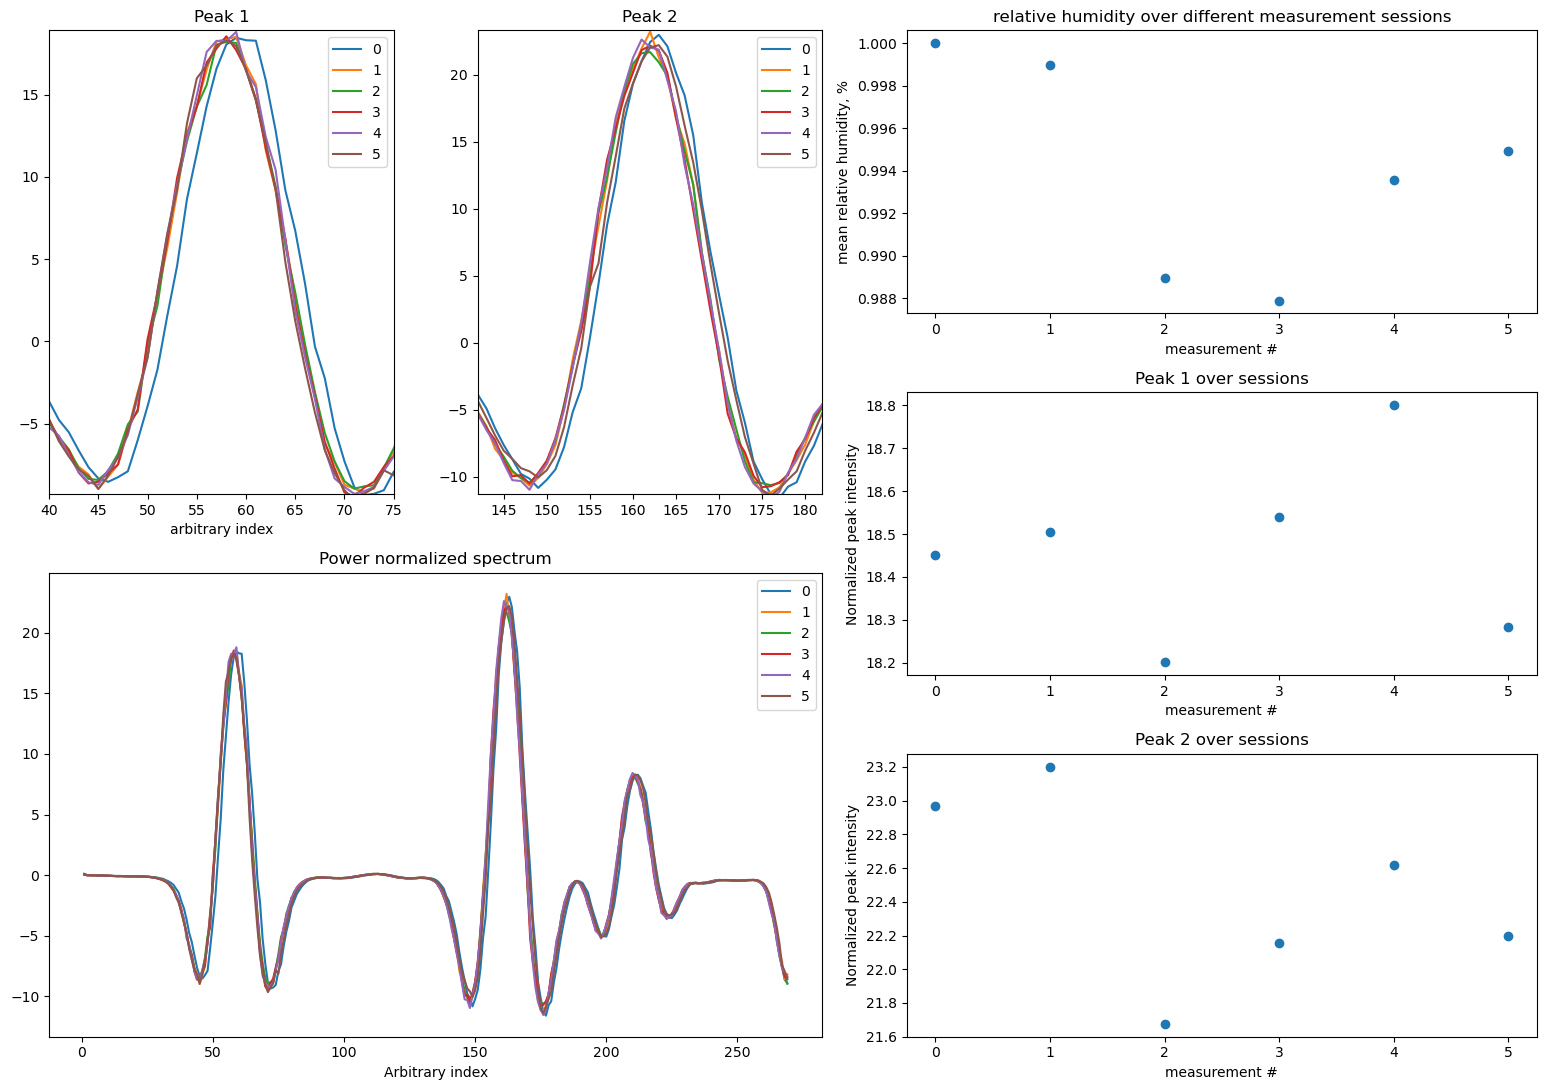

In [ ]:
path_sig = "gasx600mbar__msr__"
cm2 = CEPAS_measurement(path, path_sig, col_names)
cm2.water_plot()

In [ ]:
cm2.spectra_list[0]

,time,offset1,P1,H3,H2,P_las,T_las,RH,Pressure,time_subtracted,H2_pnorm,H3_pnorm
1,2720.914,768.0,0.0,-0.000061,2.726311e-05,-0.001233,292.2455,40.20996,600.0,0.000,0.021520,-0.047832
2,2723.023,773.0,0.0,0.000067,9.624281e-06,-0.001233,292.2383,40.20996,600.0,2.109,0.007597,0.052638
3,2725.132,778.0,0.0,-0.000015,3.086489e-06,-0.001226,292.2392,40.18555,600.0,4.218,0.002423,-0.011454
4,2727.237,783.0,0.0,0.000002,9.410022e-07,-0.001219,292.2385,40.18555,600.0,6.323,0.000735,0.001475
5,2729.340,788.0,0.0,0.000045,1.849333e-06,-0.001238,292.2407,40.16113,600.0,8.426,0.001465,0.035961
...,...,...,...,...,...,...,...,...,...,...,...,...
265,3384.542,2088.0,0.0,0.000987,-6.414715e-03,-0.001249,292.2231,40.25879,595.0,663.628,-5.127629,0.789028
266,3386.646,2093.0,0.0,0.001334,-8.102135e-03,-0.001269,292.2290,40.30762,595.0,665.732,-6.583943,1.084011
267,3388.751,2098.0,0.0,0.001813,-9.388976e-03,-0.001260,292.2339,40.30762,595.0,667.837,-7.573795,1.462784
268,3390.860,2103.0,0.0,0.001807,-1.076885e-02,-0.001251,292.2345,40.30762,595.0,669.946,-8.623766,1.446961


# Amplitude effects (@ $900\ [\text{mbar}]$) [0x20 too low, 0x66 optimal, 0x108 too high]

## Amplitude = 0x20

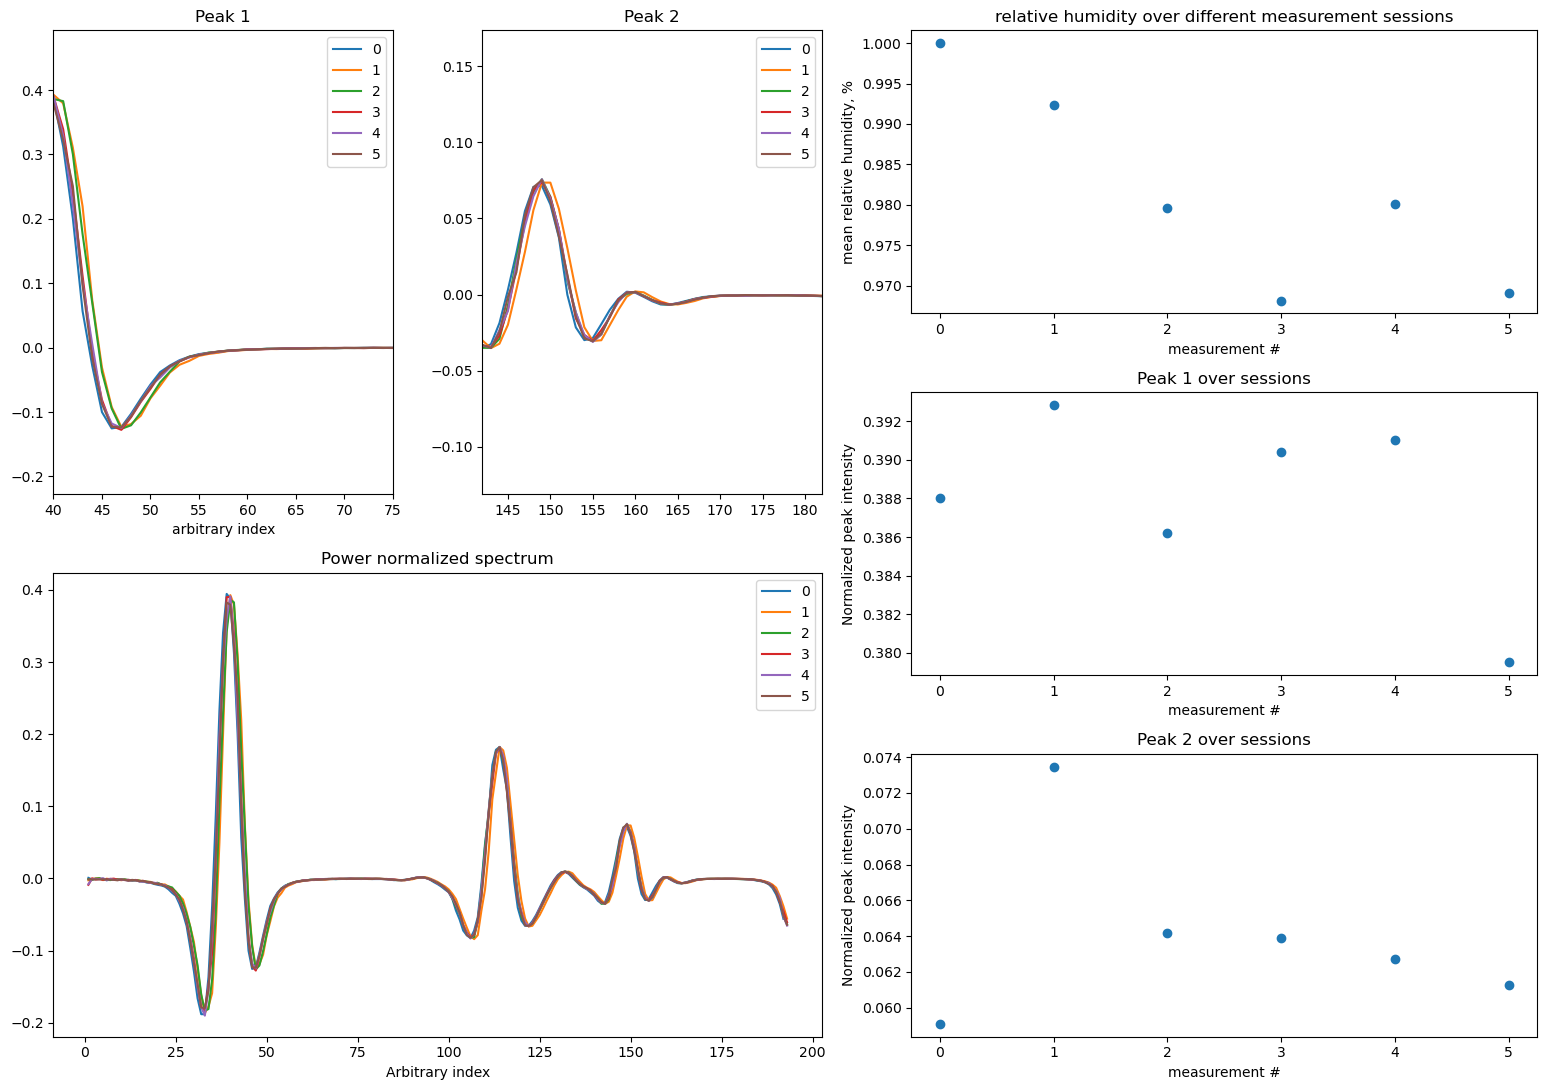

In [ ]:
path_sig = "gasx900mbar20amp__msr__"
cm3 = CEPAS_measurement(path, path_sig, col_names)
# len(cm3.spectra_list[0].columns)
cm3.water_plot()


## Amplitude = 66

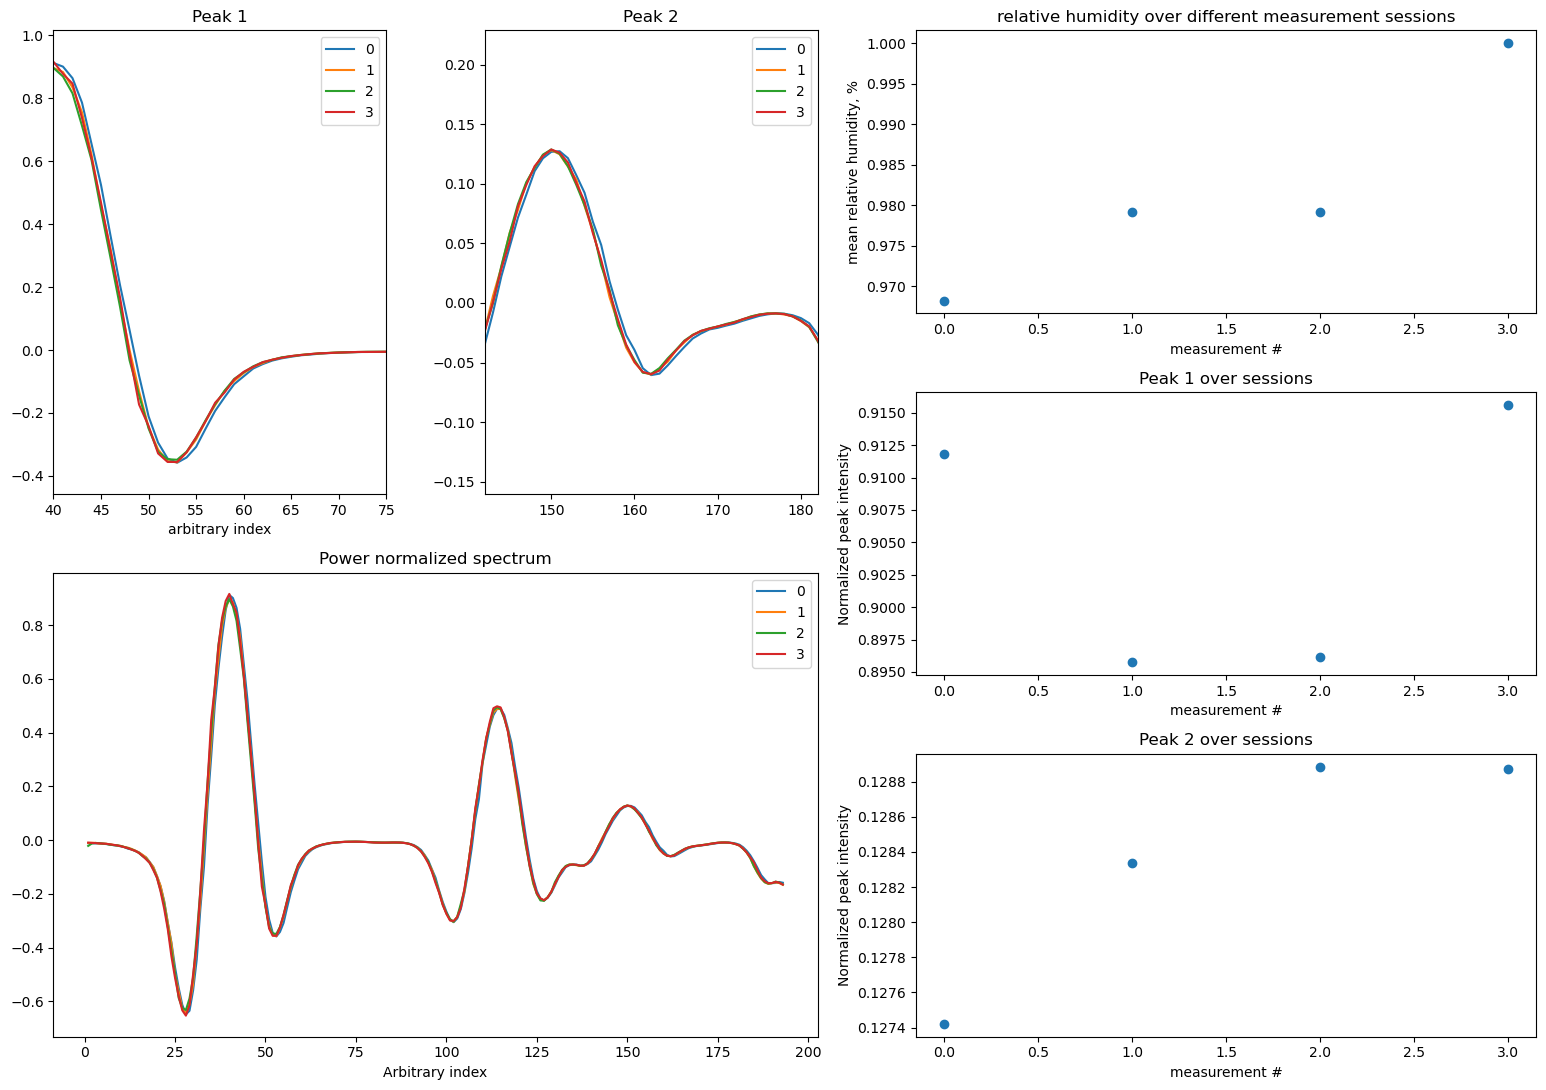

In [ ]:
path_sig = "gasx900mbar66amp__msr__"
cm4 = CEPAS_measurement(path, path_sig, col_names)
cm4.water_plot()

## Amplitude 106

In [ ]:
path_sig = "gasx900mbar106amp__msr__"
cm5 = CEPAS_measurement(path, path_sig, col_names)
# cm5.water_plot()

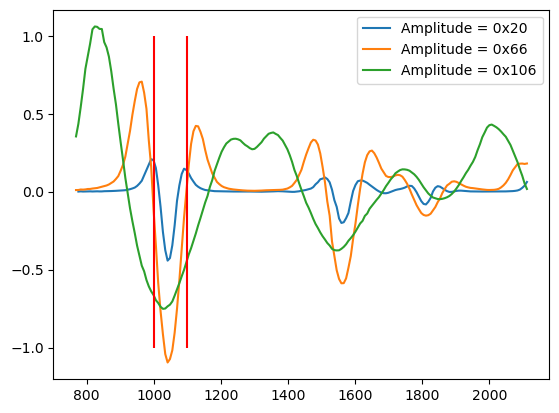

-2.0963459364193224
-1.407104337011501
-0.5346356674952111


In [ ]:
plt.plot(cm3.spectra_list[0]["offset1"], cm3.spectra_list[0]["H3_pnorm"], label="Amplitude = 0x20")
plt.plot(cm4.spectra_list[0]["offset1"], cm4.spectra_list[0]["H3_pnorm"], label="Amplitude = 0x66")
plt.plot(cm5.spectra_list[0]["offset1"], cm5.spectra_list[0]["H3_pnorm"], label="Amplitude = 0x106")
# plt.xlim(800, 1200)
plt.vlines([1000, 1100], -1, 1, colors=['red', 'red'])
plt.legend()
plt.show()

print(cm3.spectra_list[0]["H2_pnorm"].max() / cm3.spectra_list[0]["H2_pnorm"].min())
print(cm4.spectra_list[0]["H2_pnorm"].max() / cm4.spectra_list[0]["H2_pnorm"].min())
print(cm5.spectra_list[0]["H2_pnorm"].max() / cm5.spectra_list[0]["H2_pnorm"].min())

## Small amplitude range test

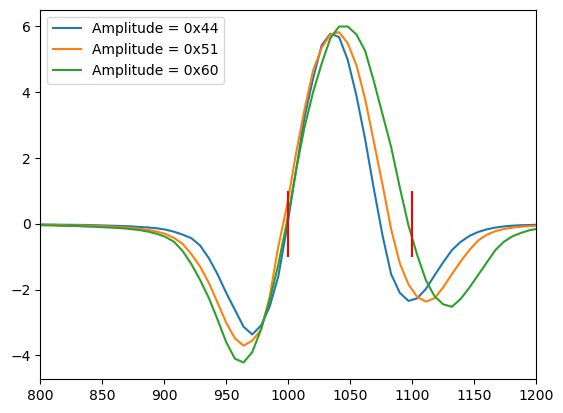

In [ ]:
path = './datas/full_tests/'
path_sig = "gasx_600_44_20__msr__"
cm6 = CEPAS_measurement(path, path_sig, col_names)
path_sig = "gasx_600_51_20__msr__"
cm7 = CEPAS_measurement(path, path_sig, col_names)
path_sig = "gasx_600_60_20__msr__"
cm8 = CEPAS_measurement(path, path_sig, col_names)
plt.plot(cm6.spectra_list[0]["offset1"], cm6.spectra_list[0]["H2_pnorm"], label="Amplitude = 0x44")
plt.plot(cm7.spectra_list[0]["offset1"], cm7.spectra_list[0]["H2_pnorm"], label="Amplitude = 0x51")
plt.plot(cm8.spectra_list[0]["offset1"], cm8.spectra_list[0]["H2_pnorm"], label="Amplitude = 0x60")
plt.xlim(800, 1200)
plt.vlines([1000, 1100], -1, 1, colors=['red', 'red'])
plt.legend()
plt.show()

1      False
2      False
3      False
4      False
5      False
       ...  
189    False
190    False
191    False
192    False
193    False
Name: H2_pnorm, Length: 193, dtype: bool


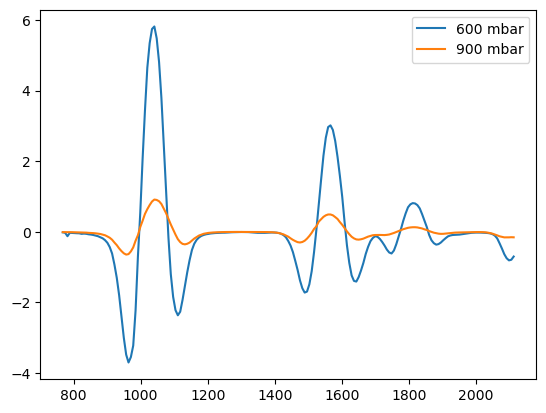

In [ ]:
print(cm7.spectra_list[0]["H2_pnorm"] == cm4.spectra_list[0]["H2_pnorm"])
plt.plot(cm7.spectra_list[0]["offset1"], cm7.spectra_list[0]["H2_pnorm"], label="600 mbar")
plt.plot(cm4.spectra_list[0]["offset1"], cm4.spectra_list[0]["H2_pnorm"], label="900 mbar")
plt.legend()
plt.show()


# Auto test (end stop did not trigger)

Testing on H2O line in the range

## from $6986$ to $6988\ \text{cm}^{-1}$

In [ ]:
amp_list = [hex(32+i*8)[2:] for i in range(14)]
print(amp_list)

['20', '28', '30', '38', '40', '48', '50', '58', '60', '68', '70', '78', '80', '88']


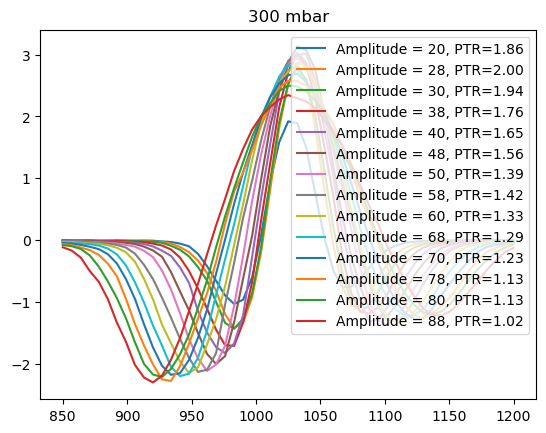

In [86]:
path3 = './datas/amptests/1/'
auto_freq_test_300 = {}
auto_amp_test_300 = {}
for i in amp_list:
    # auto_freq_test[f'cm{i}_fl'] = CEPAS_measurement(path=path2, path_signature=f"gasx_600_51_{i}__msr__", cols=col_names)
    auto_amp_test_300[f'cm{i}_fl'] = CEPAS_measurement(path=path3, path_signature=f"gasx_300_{i}_20__msr__", cols=col_names)
    # auto_test[f'cm{i}_fl'].water_plot()
    # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[0]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[0]['RH'], label=f"{i}")
    # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[1]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[1]['RH'], label=f"{i}")
    # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[2]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[2]['RH'], label=f"{i}")
    min_val = abs(auto_amp_test_300[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].min())
    max_val = abs(auto_amp_test_300[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].max())
    ratio = max_val / min_val
    plt.plot(auto_amp_test_300[f'cm{i}_fl'].spectra_list[0]['offset1'], auto_amp_test_300[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'], label=f'Amplitude = {i}, PTR={ratio:.2f}')
plt.legend(loc=1)
plt.title("300 mbar")
plt.show()

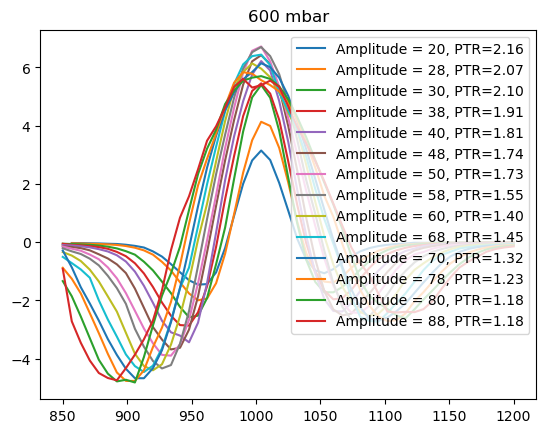

In [84]:
path4 = "./datas/amptests/2/"
auto_amp_test_600 = {}
for i in amp_list:
    # auto_freq_test[f'cm{i}_fl'] = CEPAS_measurement(path=path2, path_signature=f"gasx_600_51_{i}__msr__", cols=col_names)
    auto_amp_test_600[f'cm{i}_fl'] = CEPAS_measurement(path=path4, path_signature=f"gasx_600_{i}_20__msr__", cols=col_names)
    # auto_test[f'cm{i}_fl'].water_plot()
    # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[0]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[0]['RH'], label=f"{i}")
    # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[1]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[1]['RH'], label=f"{i}")
    # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[2]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[2]['RH'], label=f"{i}")
    min_val = abs(auto_amp_test_600[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].min())
    max_val = abs(auto_amp_test_600[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].max())
    ratio = max_val / min_val
    plt.plot(auto_amp_test_600[f'cm{i}_fl'].spectra_list[0]['offset1'], auto_amp_test_600[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'], label=f'Amplitude = {i}, PTR={ratio:.2f}')
plt.legend(loc=1)
plt.title("600 mbar")
plt.show()

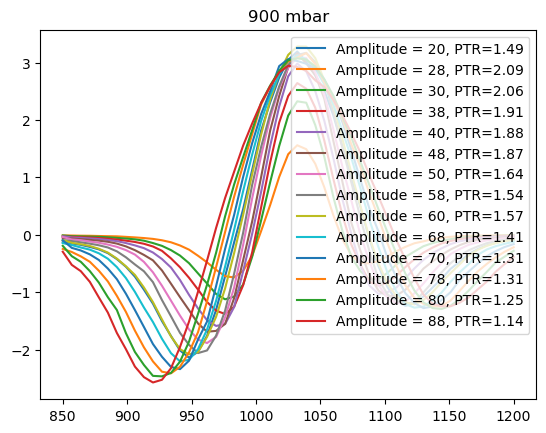

In [82]:
auto_amp_test_900 = {}
for i in amp_list:
    # auto_freq_test[f'cm{i}_fl'] = CEPAS_measurement(path=path2, path_signature=f"gasx_600_51_{i}__msr__", cols=col_names)
    auto_amp_test_900[f'cm{i}_fl'] = CEPAS_measurement(path=path3, path_signature=f"gasx_900_{i}_20__msr__", cols=col_names)
    min_val = abs(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].min())
    max_val = abs(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].max())
    ratio = max_val / min_val
    # auto_test[f'cm{i}_fl'].water_plot()
    # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[0]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[0]['RH'], label=f"{i}")
    # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[1]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[1]['RH'], label=f"{i}")
    # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[2]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[2]['RH'], label=f"{i}")
    plt.plot(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['offset1'], auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'], label=f'Amplitude = {i}, PTR={ratio:.2f}')
plt.legend(loc=1)
plt.title("900 mbar")
plt.show()

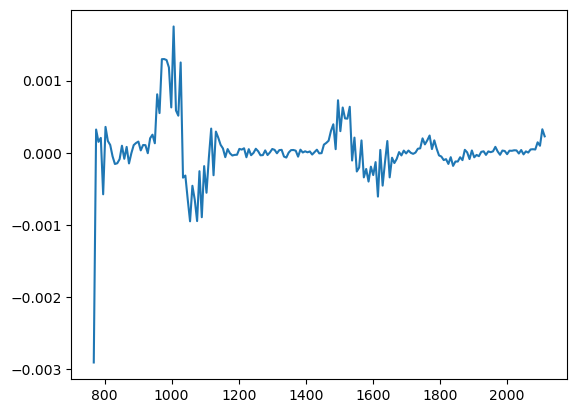

In [ ]:
cm_last = CEPAS_measurement(path=path2, path_signature="gasx_600_51_300__msr__", cols=col_names)
plt.plot(cm_last.spectra_list[0]['offset1'], cm_last.spectra_list[0]['H3_pnorm'])

# Peak/trough ratio

In [ ]:
auto_amp_tests = {
    '300': auto_amp_test_300,
    '600': auto_amp_test_600,
    '900': auto_amp_test_900
}

def extract_PT_ratios(tests: dict) -> dict:
    for_barplot = {}
    for test in list(tests.keys()):
        print(test)
        for_barplot[test] = {}
        for subtest in tests[test]:
            min_val = abs(tests[test][subtest].spectra_list[0]['H2_pnorm'].min())
            max_val = abs(tests[test][subtest].spectra_list[0]['H2_pnorm'].max())
            ratio = max_val / min_val
            key = f"Amplitude: {subtest}"
            value = ratio
            for_barplot[test][key] = value
    
    return for_barplot

extract_PT_ratios(auto_amp_tests)

300
600
900


{'300': {'Amplitude: cm20_fl': 1.8572713427997576,
  'Amplitude: cm28_fl': 2.0008222960484106,
  'Amplitude: cm30_fl': 1.9438575305495334,
  'Amplitude: cm38_fl': 1.762320889490436,
  'Amplitude: cm40_fl': 1.6506866033833827,
  'Amplitude: cm48_fl': 1.5617129296110441,
  'Amplitude: cm50_fl': 1.3897437074053178,
  'Amplitude: cm58_fl': 1.4184613990501653,
  'Amplitude: cm60_fl': 1.3344244237293932,
  'Amplitude: cm68_fl': 1.2879978759832391,
  'Amplitude: cm70_fl': 1.234607380678039,
  'Amplitude: cm78_fl': 1.1282843521561705,
  'Amplitude: cm80_fl': 1.1276990716844901,
  'Amplitude: cm88_fl': 1.0176601718405858},
 '600': {'Amplitude: cm20_fl': 2.1645434435274864,
  'Amplitude: cm28_fl': 2.073982349950032,
  'Amplitude: cm30_fl': 2.0964593786476198,
  'Amplitude: cm38_fl': 1.9051788159380239,
  'Amplitude: cm40_fl': 1.8103806491658478,
  'Amplitude: cm48_fl': 1.7448534680695034,
  'Amplitude: cm50_fl': 1.7259067403295945,
  'Amplitude: cm58_fl': 1.5462623130055173,
  'Amplitude: cm60_f

# Whiteboard

In [ ]:
diff74 = subtract_hex("90e1", "9f91")
sum_hex(diff74, "91d1")

'0xa081'

In [ ]:
print(int("49", 16))
print(int("5B", 16))
print(int("66", 16))

73
91
102


In [ ]:
np.round(np.geomspace(32, 300, 9, endpoint=True))

array([ 32.,  42.,  56.,  74.,  98., 130., 171., 227., 300.])

# Misc

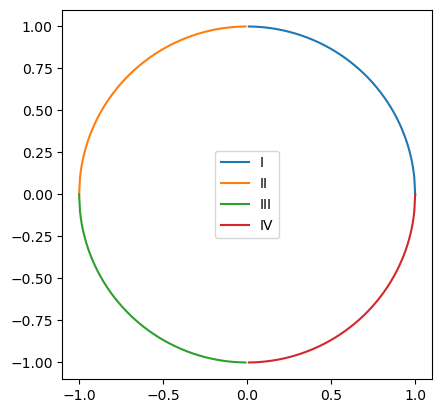

In [ ]:
plt.gca().set_aspect('equal')
r = 1
A = np.pi * r**2
x_arr = np.linspace(0.01, 1, 200)
def circle(x, r=1.0):
    expression = r - np.pow(x, 2)
    return np.sqrt(expression)

# print(x_arr)

plt.plot(x_arr, circle(x_arr, r), label="I")
plt.plot(-x_arr, circle(x_arr, r), label="II")
plt.plot(-x_arr, -circle(x_arr, r), label="III")
plt.plot(x_arr, -circle(x_arr, r), label="IV")
plt.legend()
plt.show()

In [ ]:
area_test, err = quad(circle, 0, 1, args=(1,))
print(round(4*area_test, 14))
print(round(np.pi, 14))


3.14159265358979
3.14159265358979


In [ ]:
def custom_integral(f, x1, x0=0, step_denominator=1e6):
    dx = 1/step_denominator
    x_values = np.linspace(x0+dx, x1, int(step_denominator))
    return np.sum(f(x_values, x1)*dx)

4*custom_integral(f=circle, x1=1.0)

np.float64(3.1415906524138117)